In [1]:
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import tree

In [2]:
df = pd.read_csv('titanic.csv')
print(len(df))
df.head()

891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data preprocessing

In [3]:
y = df['Survived']
X = df.drop(columns=['Survived'])

### Missing values

In [4]:
total = X.isnull().sum().sort_values(ascending=False)
percent_1 = X.isnull().sum()/X.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


In [5]:
import re
##### CABIN #####
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

X['Cabin'] = X['Cabin'].fillna("U0")
X['Deck'] = X['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
X['Deck'] = X['Deck'].map(deck)
X['Deck'] = X['Deck'].fillna(0)
X['Deck'] = X['Deck'].astype(int)
X = X.drop(['Cabin'], axis=1)

##### AGE #####
mean = X["Age"].mean()
std = X["Age"].std()
is_null = X["Age"].isnull().sum()
# compute random numbers between the mean, std and is_null
rand_age = np.random.randint(mean - std, mean + std, size = is_null)
# fill NaN values in Age column with random values generated
age_slice = X["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
X["Age"] = age_slice
X["Age"] = X["Age"].astype(int)
X["Age"].isnull().sum()

##### EMBARKED #####
#X['Embarked'].describe()
common_value = 'S'
X['Embarked'] = X['Embarked'].fillna(common_value)

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          891 non-null    int64  
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
 10  Deck         891 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 76.7+ KB


### Change types

In [7]:
##### FARE #####
X['Fare'] = X['Fare'].fillna(0)
X['Fare'] = X['Fare'].astype(int)

##### NAME #####
# extract titles
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
X['Title'] = X.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
# replace titles with a more common title or as Rare
X['Title'] = X['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                        'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
X['Title'] = X['Title'].replace('Mlle', 'Miss')
X['Title'] = X['Title'].replace('Ms', 'Miss')
X['Title'] = X['Title'].replace('Mme', 'Mrs')
# convert titles into numbers
X['Title'] = X['Title'].map(titles)
# filling NaN with 0, to get safe
X['Title'] = X['Title'].fillna(0)
X = X.drop(['Name'], axis=1)

##### SEX #####
genders = {"male": 0, "female": 1}
X['Sex'] = X['Sex'].map(genders)

##### TICKET #####
X = X.drop(['Ticket'], axis=1)

##### EMBARKED #####
ports = {"S": 0, "C": 1, "Q": 2}
X['Embarked'] = X['Embarked'].map(ports)

In [8]:
X['Age'] = X['Age'].astype(int)
X.loc[X['Age'] <= 11, 'Age'] = 0
X.loc[(X['Age'] > 11) & (X['Age'] <= 18), 'Age'] = 1
X.loc[(X['Age'] > 18) & (X['Age'] <= 22), 'Age'] = 2
X.loc[(X['Age'] > 22) & (X['Age'] <= 27), 'Age'] = 3
X.loc[(X['Age'] > 27) & (X['Age'] <= 33), 'Age'] = 4
X.loc[(X['Age'] > 33) & (X['Age'] <= 40), 'Age'] = 5
X.loc[(X['Age'] > 40) & (X['Age'] <= 66), 'Age'] = 6
X.loc[X['Age'] > 66, 'Age'] = 6
X['Age'].value_counts()

6    174
4    159
5    149
3    139
2    114
1     88
0     68
Name: Age, dtype: int64

For the ‘Fare’ feature, we need to do the same as with the ‘Age’ feature. But it isn’t that easy, because if we cut the range of the fare values into a few equally big categories, 80% of the values would fall into the first category. Fortunately, we can use sklearn **qcut()** function, that we can use to see, how we can form the categories.

In [9]:
X.loc[X['Fare'] <= 7.91, 'Fare'] = 0
X.loc[(X['Fare'] > 7.91) & (X['Fare'] <= 14.454), 'Fare'] = 1
X.loc[(X['Fare'] > 14.454) & (X['Fare'] <= 31), 'Fare']   = 2
X.loc[(X['Fare'] > 31) & (X['Fare'] <= 99), 'Fare']   = 3
X.loc[(X['Fare'] > 99) & (X['Fare'] <= 250), 'Fare']   = 4
X.loc[X['Fare'] > 250, 'Fare'] = 5
X['Fare'] = X['Fare'].astype(int)

## Model

In [10]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

In [11]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
#model = DecisionTreeClassifier()
model.fit(train_X, train_y)

prediction = model.predict(val_X)

In [12]:
print(val_y.value_counts())
predictions = model.predict(val_X)
print(confusion_matrix(predictions, val_y))
print(classification_report(predictions, val_y))
print(accuracy_score(predictions, val_y))

0    139
1     84
Name: Survived, dtype: int64
[[123  24]
 [ 16  60]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       147
           1       0.71      0.79      0.75        76

    accuracy                           0.82       223
   macro avg       0.80      0.81      0.81       223
weighted avg       0.83      0.82      0.82       223

0.820627802690583


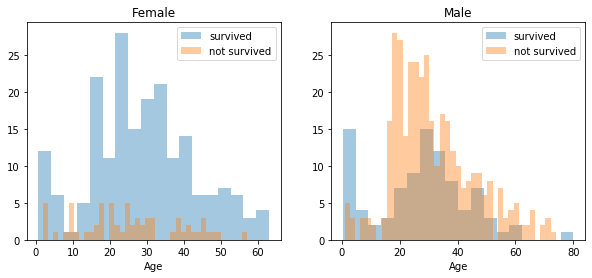

In [13]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = df[df['Sex']=='female']
men = df[df['Sex']=='male']

ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')

ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

## Permutation importance

In [14]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(val_X, val_y)
eli5.show_weights( perm, feature_names = val_X.columns.tolist() )

# titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

/Users/john/miniconda3/envs/systems/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/john/miniconda3/envs/systems/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.1112 ± 0.0407,Title
0.0520 ± 0.0166,Sex
0.0359 ± 0.0443,Pclass
0.0179 ± 0.0241,Fare
0.0152 ± 0.0091,SibSp
0.0081 ± 0.0369,Embarked
0.0081 ± 0.0262,Age
0.0054 ± 0.0119,Parch
0.0036 ± 0.0243,Deck
-0.0063 ± 0.0251,PassengerId


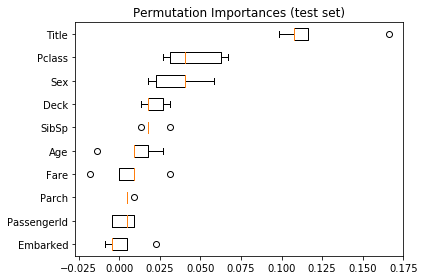

In [15]:
from sklearn.inspection import permutation_importance

perm2 = permutation_importance(model, random_state=1,
                       X=val_X, y=val_y)
sorted_idx = perm2.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(perm2.importances[sorted_idx].T,
           vert=False, labels=val_X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Partial Dependence Plots

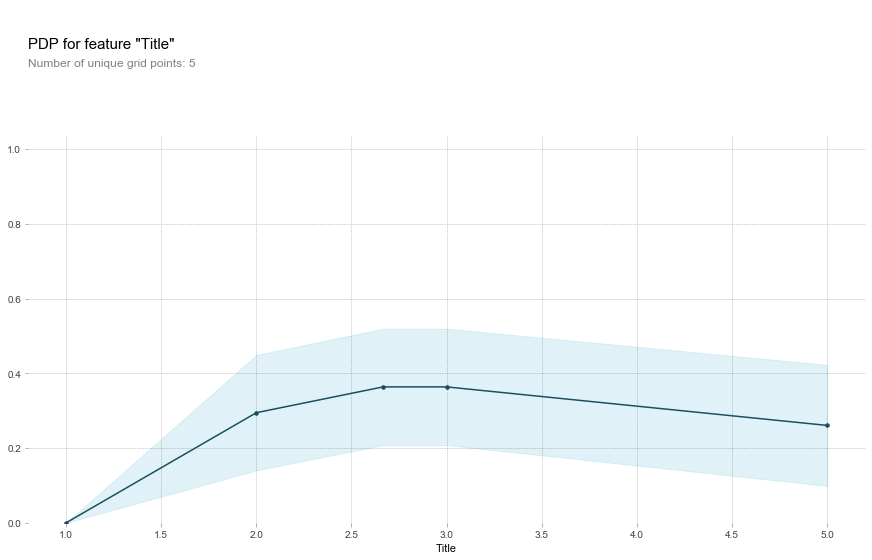

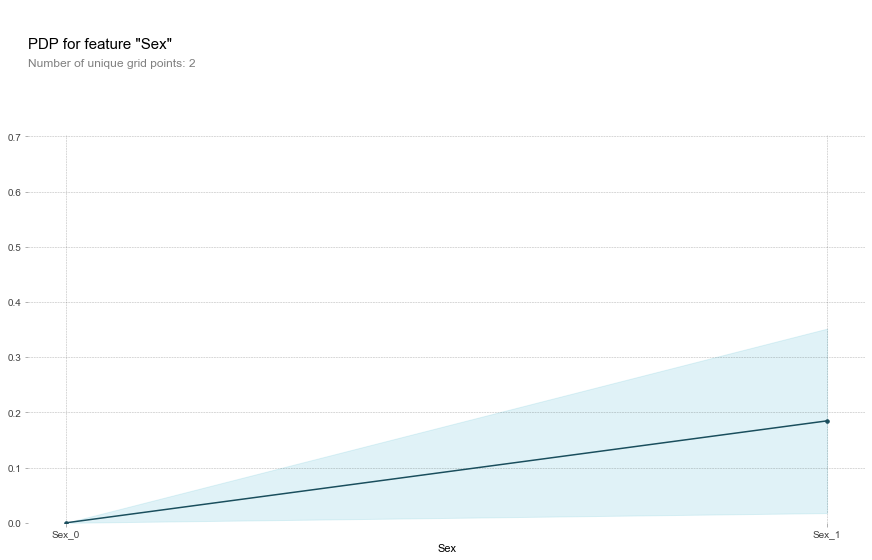

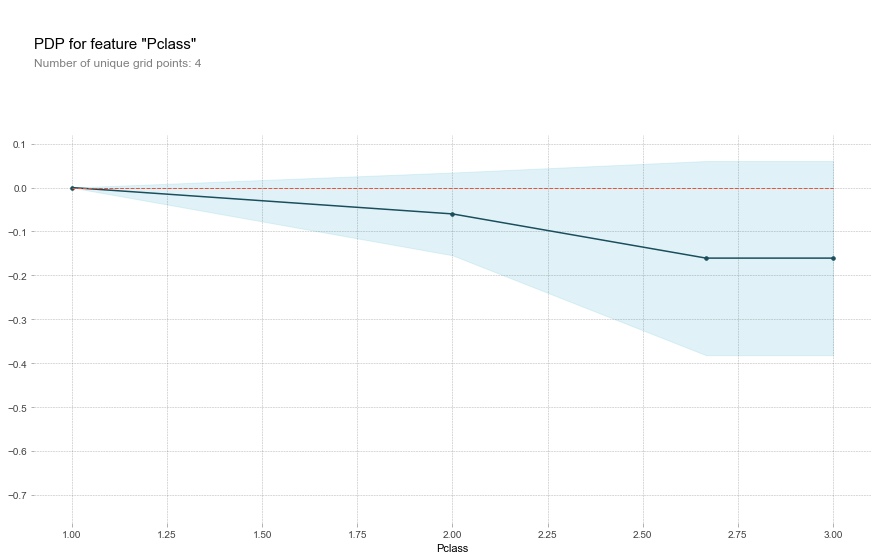

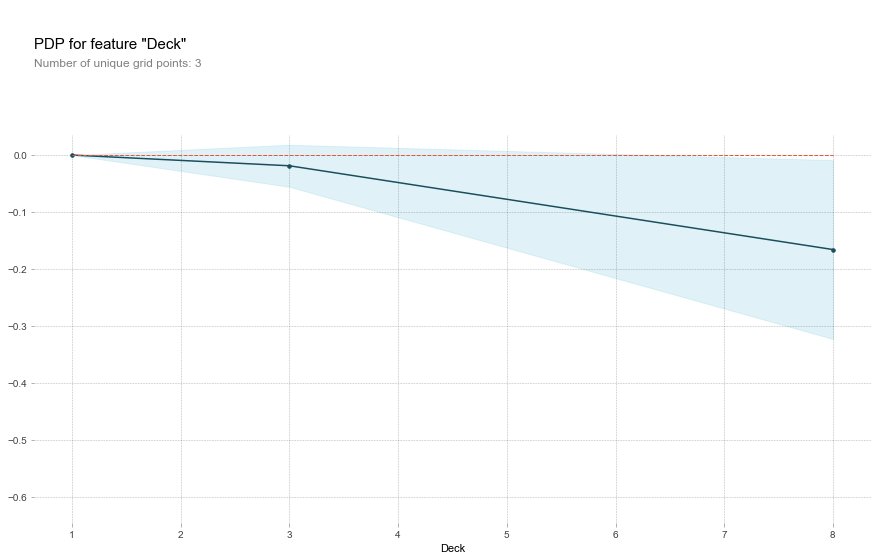

In [16]:
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
features_to_explore = ['Title', 'Sex', 'Pclass', 'Deck']

for feat in features_to_explore:
    pdp_goals = pdp.pdp_isolate(model=model,
                                dataset=val_X,
                                model_features=X.columns,
                                feature=feat)

    # plot it
    pdp.pdp_plot(pdp_goals, feat)
    plt.show()

A few items are worth pointing out as you interpret this plot

- The **y axis** is interpreted as **change in the prediction** from what it would be predicted at the baseline or leftmost value.
- A blue shaded area indicates level of confidence

## 2D Partial Dependence Plots

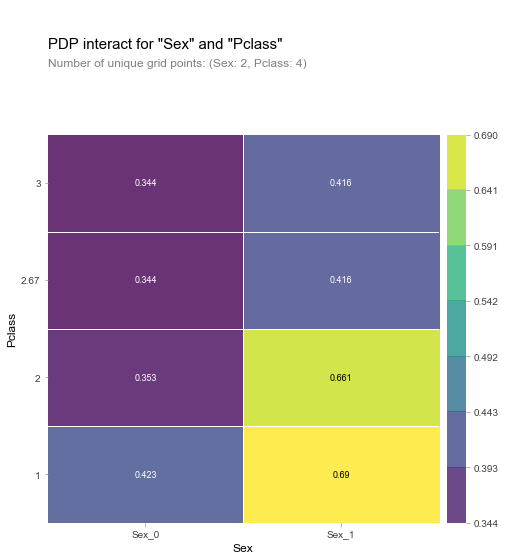

In [17]:
features_to_plot = ['Sex', 'Pclass']
inter = pdp.pdp_interact(model=model,
                         dataset=val_X,
                         model_features=X.columns,
                         features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter,
                      feature_names=features_to_plot,
                      plot_type='grid')
plt.show()

In [18]:
X[X['Sex'] == 1].groupby(by='Pclass').count()

,PassengerId,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
Pclass,,,,,,,,,
1,94,94,94,94,94,94,94,94,94
2,76,76,76,76,76,76,76,76,76
3,144,144,144,144,144,144,144,144,144


In [20]:
# we repeatedly alter the value for one variable
#tree_graph = tree.export_graphviz(model, out_file=None, feature_names=X.columns)
#graphviz.Source(tree_graph)

## SHAP Values

SHAP Values (an acronym from **SHapley Additive exPlanations**) break down a prediction to show the impact of each feature. 

We'll use SHAP Values to **explain individual predictions**.

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

But it's easier to give a concrete, numeric answer if we restate this as:

- How much was a prediction driven by the fact that the team scored 3 goals, instead of some baseline number of goals.
- Of course, each team has many features. So if we answer this question for number of goals, we could repeat the process for all other features.

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

In [21]:
row = 5

row_to_predict = val_X.iloc[5].values.reshape(1,-1)
pred = model.predict(row_to_predict)
pred_proba =model.predict_proba(row_to_predict)

print(f"Real output: {y.iloc[5]}")
print(f"Prediction: {pred[0]}")
print(f"Probabilities: {dict(zip((1, 0), (pred_proba[0])))}")



Real output: 0
Prediction: 0
Probabilities: {1: 0.65, 0: 0.35}


In [22]:
import shap

# load JS visualization code to notebook
shap.initjs()

explainer = shap.TreeExplainer(model)
# [0] - the SHAP values for a negative outcome; [1] = positive outcome
shap_values = explainer.shap_values(row_to_predict)
shap.force_plot(explainer.expected_value[1],
                shap_values[1],
                row_to_predict)

In [23]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val_X)
shap.force_plot(explainer.expected_value[1], shap_values[1], val_X)

This plot is made of many dots. Each dot has three characteristics:

- Vertical location shows what feature it is depicting <br>
- Color shows whether that feature was high or low for that row of the dataset <br>
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

However if **all dots on the graph are widely spread from each other**, that is a reasonable indication that **permutation importance is high**. Because the range of effects is so sensitive to outliers, permutation importance is a better measure of what's generally important to the model.

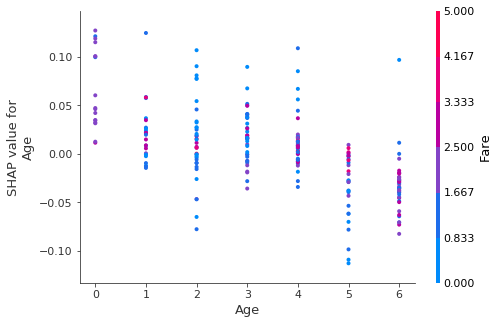

In [24]:
shap.dependence_plot('Age', shap_values[1], val_X,
                     interaction_index='Fare')

In [25]:
# Approximate results
k_explainer = shap.KernelExplainer(model.predict_proba, train_X)
k_shap_values = k_explainer.shap_values(row_to_predict)
shap.force_plot(k_explainer.expected_value[1],
               k_shap_values[1],
               row_to_predict)

Using 668 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


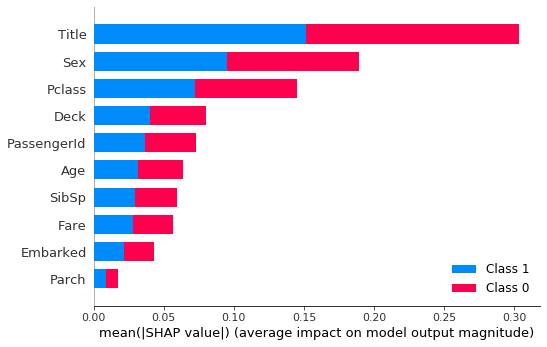

In [26]:
# summarize the effects of all the features
shap.summary_plot(shap_values, val_X)

``shap.DeepExplainer`` works with Deep Learning models.

``shap.KernelExplainer`` works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.

## Advanced Uses 